## 1. Settings

## 1.1 Setting up the environment

In [1]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss

from ase.build import molecule

Tensor = torch.Tensor

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

## 1.2 Setting up the molecular systems for training

In [2]:
# Provide a list of moecules for training
molecule_names = ['CH4', 'H2O']

# Reference of target properties
targets = {'q_final_atomic': torch.tensor(
    [[4.251914, 0.937022, 0.937022, 0.937022, 0.937022],
     [6.526248, 0.736876, 0.736876, 0, 0]])}

# Provide information about the orbitals on each atom; this is keyed by atomic
# numbers and valued by azimuthal quantum numbers like so:
#   {Z₁: [ℓᵢ, ℓⱼ, ..., ℓₙ], Z₂: [ℓᵢ, ℓⱼ, ..., ℓₙ], ...}
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

## 1.3 Setting up the model for training

In [3]:
# Before running this example, please use setup.ipynb to download the parameter set needed
# Location at which the DFTB parameter set database is located
parameter_db_path = '../../../data/example_dftb_parameters.h5'

# Type of ML model
model = 'spline'

# Whether performing model fitting
fit_model = True

# Number of training cycles
number_of_epochs = 10

# Learning rate
lr = 0.002

# Loss function
loss_func = mse_loss

## 1.4 Setting up the DFTB calculator

## 1.4.1 Input the molecular systems

In [4]:
# Construct the `Geometry` and `OrbitalInfo` objects. The former is analogous
# to the ase.Atoms object while the latter provides information about what
# orbitals are present and which atoms they belong to.
geometry = Geometry.from_ase_atoms(list(map(molecule, molecule_names)))
orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict, shell_resolved=False)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
# Strip out padding species and convert to a standard list.
species = species[species != 0].tolist()

## 1.4.2 Loading of the DFTB parameters into their associated feed objects

In [5]:
# Load the Hamiltonian feed model
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True,
                              requires_grad_offsite=True)

# Load the overlap feed model
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline, requires_grad_onsite=True,
                              requires_grad_offsite=True)

# Load the occupation feed object
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)

# Load the Hubbard-U feed object
u_feed = HubbardFeed.from_database(parameter_db_path, species)

## 1.4.3 Constructing the SCC-DFTB calculator

In [6]:
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, filling_scheme=None)

## 2. Data preparation

In [7]:
# Define a delegate to obtain predictions from the trained model
def prediction_delegate(calculator, targets, **kwargs):
     predictions = dict()
     predictions["mulliken"] = calculator.q_final_atomic
     
     return predictions

In [8]:
# Define a delegate to obtain reference results
def reference_delegate(calculator, targets, **kwargs):
     references = dict()
     references["mulliken"] = targets['q_final_atomic']

     return references

## 3. Model training

In [9]:
# Define parameters to optimize
h_var = [param for name, param in h_feed.named_parameters()]
s_var = [param for name, param in s_feed.named_parameters()]
variable = h_var + s_var

In [10]:
# Define the loss entity
loss_entity = Loss(prediction_delegate, reference_delegate,
                   loss_functions=loss_func, reduction='mean')

In [11]:
# Define optimizer
optimizer = getattr(torch.optim, 'Adam')(params=variable, lr=lr)

In [12]:
# Execution
loss_list = []
loss_list.append(0)
for epoch in range(number_of_epochs):
    _loss = 0
    print('epoch', epoch)
    dftb_calculator(geometry, orbs, grad_mode="direct")
    total_loss, raw_losses = loss_entity(dftb_calculator, targets)
    _loss = _loss + total_loss
    optimizer.zero_grad()
    _loss.retain_grad()

    # Invoke the autograd engine
    _loss.backward(retain_graph=True)

    # Update the model
    optimizer.step()
    print("loss:", _loss)
    loss_list.append(_loss.detach())

epoch 0
loss: tensor(0.0009, grad_fn=<AddBackward0>)
epoch 1
loss: tensor(0.0003, grad_fn=<AddBackward0>)
epoch 2
loss: tensor(0.0001, grad_fn=<AddBackward0>)
epoch 3
loss: tensor(0.0002, grad_fn=<AddBackward0>)
epoch 4
loss: tensor(0.0002, grad_fn=<AddBackward0>)
epoch 5
loss: tensor(0.0001, grad_fn=<AddBackward0>)
epoch 6
loss: tensor(6.5845e-05, grad_fn=<AddBackward0>)
epoch 7
loss: tensor(5.5948e-05, grad_fn=<AddBackward0>)
epoch 8
loss: tensor(9.1647e-05, grad_fn=<AddBackward0>)
epoch 9
loss: tensor(0.0001, grad_fn=<AddBackward0>)


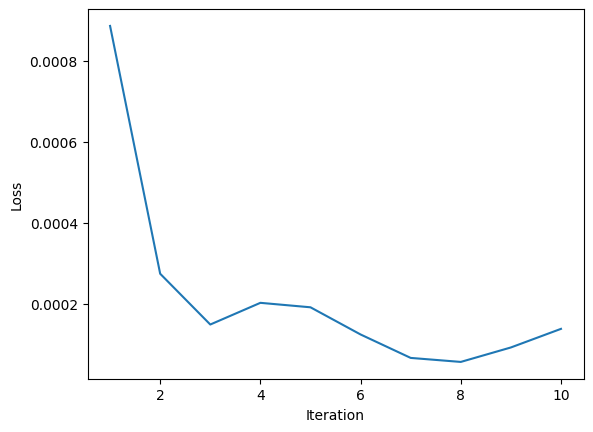

In [13]:
# Plot the loss
import matplotlib.pyplot as plt
plt.plot(torch.linspace(1, number_of_epochs, number_of_epochs),
         loss_list[1:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()